In [1]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt

Pendiente: 0.018327575464321705
Intersección: -0.3638999200192323
Coeficiente de correlación: 0.9985095033358795


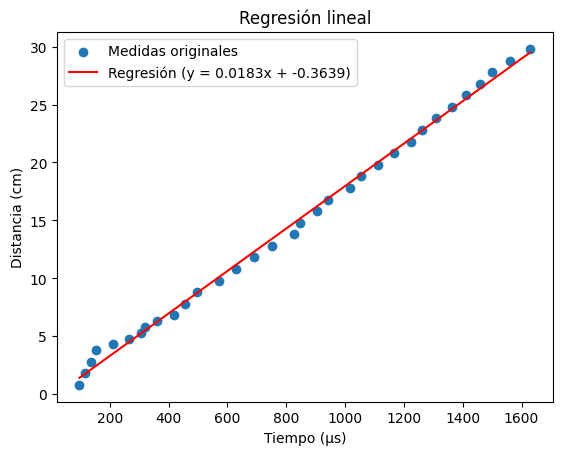

In [7]:
# Medidas distancia real vs tiempo (en microsegundos) que midió el sensor
# para la ida y vuelta de la onda ultrasónica.

df = pd.read_csv("./assets/DATA/calibration.csv")
x = df["Distancia"]
y = df["Tiempo"]
slope, intercept, r_value, p_value, std_err = linregress(y, x)

print(f"Pendiente: {slope}")
print(f"Intersección: {intercept}")
print(f"Coeficiente de correlación: {r_value}")

plt.scatter(y, x, label="Medidas originales")
plt.plot(y, slope * y + intercept, color="red", label=f"Regresión (y = {slope:.4f}x + {intercept:.4f})")
plt.ylabel("Distancia (cm)")
plt.xlabel("Tiempo (µs)")
plt.title("Regresión lineal")
plt.legend()
plt.show()

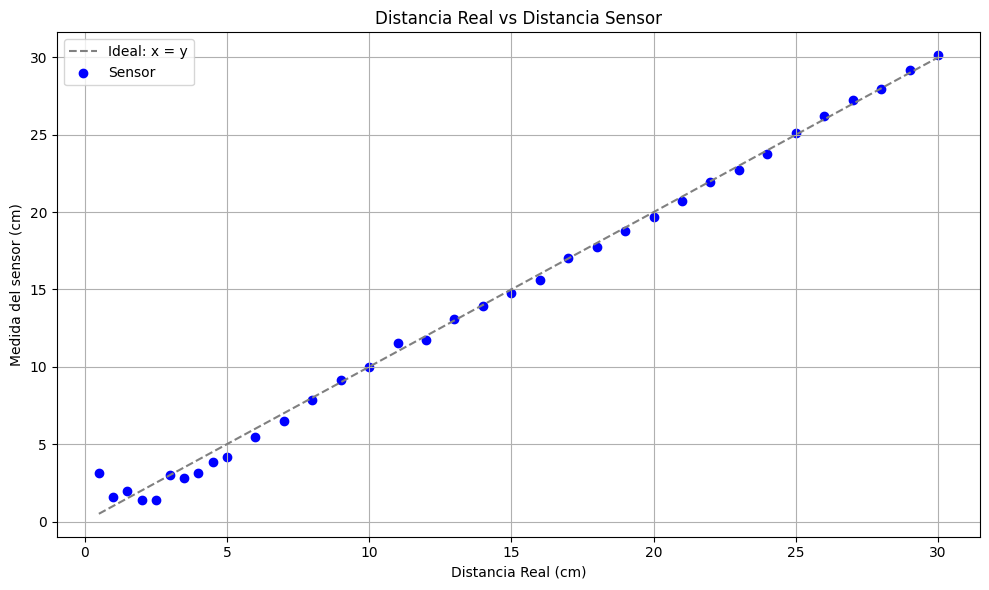

Error absoluto medio: 0.3974285714285713
Error cuadrático medio: 0.3764771428571428
Raíz del error cuadrático medio: 0.6135773324179624
Error absoluto medio (0-10cm): 0.6921428571428571
Error absoluto medio (mayor a 20cm): 0.18200000000000002


In [8]:
# Datos obtenidos a de las mediciones de distancia
# utilizando la calibración anteriormente calculada.

  # duration = pulseIn(ECHO_PIN, HIGH);
  # Serial.println(duration * 0.0183 - 0.3639);

df = pd.read_csv("./assets/DATA/calibration_test.csv")
df["Error"] = df["Sensor"] - df["Real"]
df["ErrorAbs"] = df["Error"].abs()
df["ErrorCuad"] = df["Error"] ** 2

err_abs_medio = df["ErrorAbs"].mean()
ecm = df["ErrorCuad"].mean()
recm = np.sqrt(ecm)

range_0_10 = df[(df["Real"] > 0) & (df["Real"] < 10)]
range_gt_20 = df[df["Real"] > 20]

err_abs_medio_0_10 = range_0_10["ErrorAbs"].mean()
err_abs_medio_mayor_20 = range_gt_20["ErrorAbs"].mean()


plt.figure(figsize=(10, 6))
plt.plot(df["Real"], df["Real"], label="Ideal: x = y", linestyle='--', color='gray')
plt.scatter(df["Real"], df["Sensor"], label="Sensor", color='blue')
plt.title("Distancia Real vs Distancia Sensor")
plt.xlabel("Distancia Real (cm)")
plt.ylabel("Medida del sensor (cm)")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

print(f"Error absoluto medio: {err_abs_medio}")
print(f"Error cuadrático medio: {ecm}")
print(f"Raíz del error cuadrático medio: {recm}")
print(f"Error absoluto medio (0-10cm): {err_abs_medio_0_10}")
print(f"Error absoluto medio (mayor a 20cm): {err_abs_medio_mayor_20}")

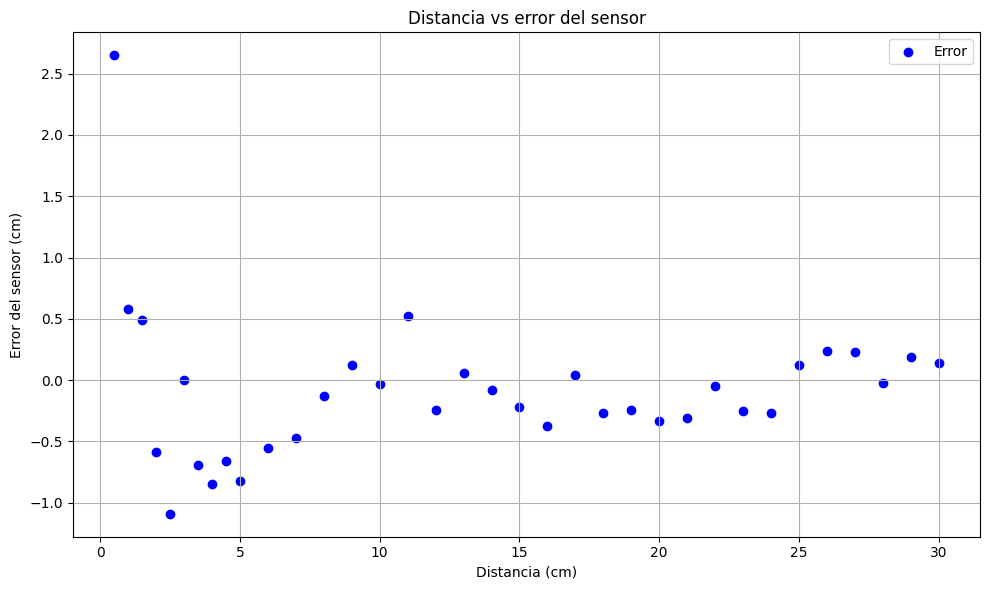

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(df["Real"], df["Error"], label="Error", color='blue')
plt.title("Distancia vs error del sensor")
plt.xlabel("Distancia (cm)")
plt.ylabel("Error del sensor (cm)")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [10]:
# Para intentar corregir un poco el error, se hace la regresión de
# la distancia real a partir de la medida del sensor.
slope, intercept, r_value, p_value, std_err = linregress(df["Sensor"], df["Real"])

print(f"Pendiente: {slope}")
print(f"Intersección: {intercept}")
print(f"Coeficiente de correlación: {r_value}")

# En este caso, x sería: duration * 0.0183 - 0.3639
print(f"Función corregida: y = (x + {-intercept}) / {slope}")

Pendiente: 0.9941517873158765
Intersección: 0.16925999104897116
Coeficiente de correlación: 0.997852930355362
Función corregida: y = (x + -0.16925999104897116) / 0.9941517873158765


In [11]:
data = [
    (20, 19.91),
    (21, 20.94),
    (22, 22.30),
    (23, 23.01),
    (24, 24.85),
    (25, 25.49),
    (26, 25.80),
    (27, 27.30),
    (28, 28.50),
    (29, 29.50),
    (30, 30.64),
    (31, 31.47),
    (32, 32.30),
    (33, 33.44),
    (34, 34.55),
    (35, 35.67)
]

correction_df = pd.DataFrame(data, columns=["Real", "Sensor"])
correction_df["Error"] = correction_df["Sensor"] - correction_df["Real"]

correction_err_abs_medio_mayor_20 = correction_df["Error"].abs().mean()

print(f"Error absoluto medio (mayor a 20cm) en la corrección: {correction_err_abs_medio_mayor_20}")
print(f"Error relativo (mayor a 20cm) originalmente: {err_abs_medio_mayor_20}")
aumento = (abs(correction_err_abs_medio_mayor_20 - err_abs_medio_mayor_20)/err_abs_medio_mayor_20)*100
print(f"Aumento: {aumento:.1f}%")

Error absoluto medio (mayor a 20cm) en la corrección: 0.3981249999999996
Error relativo (mayor a 20cm) originalmente: 0.18200000000000002
Aumento: 118.7%


# Filtro de Hampel
En la siguiente sección se presenta un algoritmo de Filtro de Hampel para remover el ruido en los datos de rapidez obtenidos por el sensor.

In [16]:
def filtro_hampel(data, window_size=7, threshold=3):
    """
    Aplica el filtro de Hampel para eliminar y detectar datos atípicos.

    Parametros:
    - data: datos a filtrar (debe ser un array o lista de números)
    - window_size: int, tamaño de la ventana para el filtro (debe ser impar)
    - threshold: float, umbral para detectar outliers (valor típico es 3)

    Devuelve:
    - filtered_data: datos filtrados sin outliers
    - outlier_indices: índices de los outliers detectados
    - outlier_values: valores de los outliers detectados
    """
    data = np.array(data)
    filtered_data = data.copy()
    outlier_indices = []
    outlier_values = []

    if window_size % 2 == 0:
        window_size += 1

    half_window = window_size // 2

    for i in range(len(data)):
        start = max(0, i - half_window)
        end = min(len(data), i + half_window + 1)

        window = data[start:end]

        median = np.median(window)
        mad = np.median(np.abs(window - median))

        if mad != 0:
            modified_z_score = 0.6745 * (data[i] - median) / mad
        else:
            modified_z_score = 0

        # Revisa si el punto es un valor atípico
        if np.abs(modified_z_score) > threshold:
            outlier_indices.append(i)
            outlier_values.append(data[i])
            filtered_data[i] = median

    return filtered_data, outlier_indices, outlier_values


Applying Hampel filter...

Archivos guardados satisfactoriamente!
- cleaned_data.csv (227 filas)
- outliers_data.csv (150 filas)


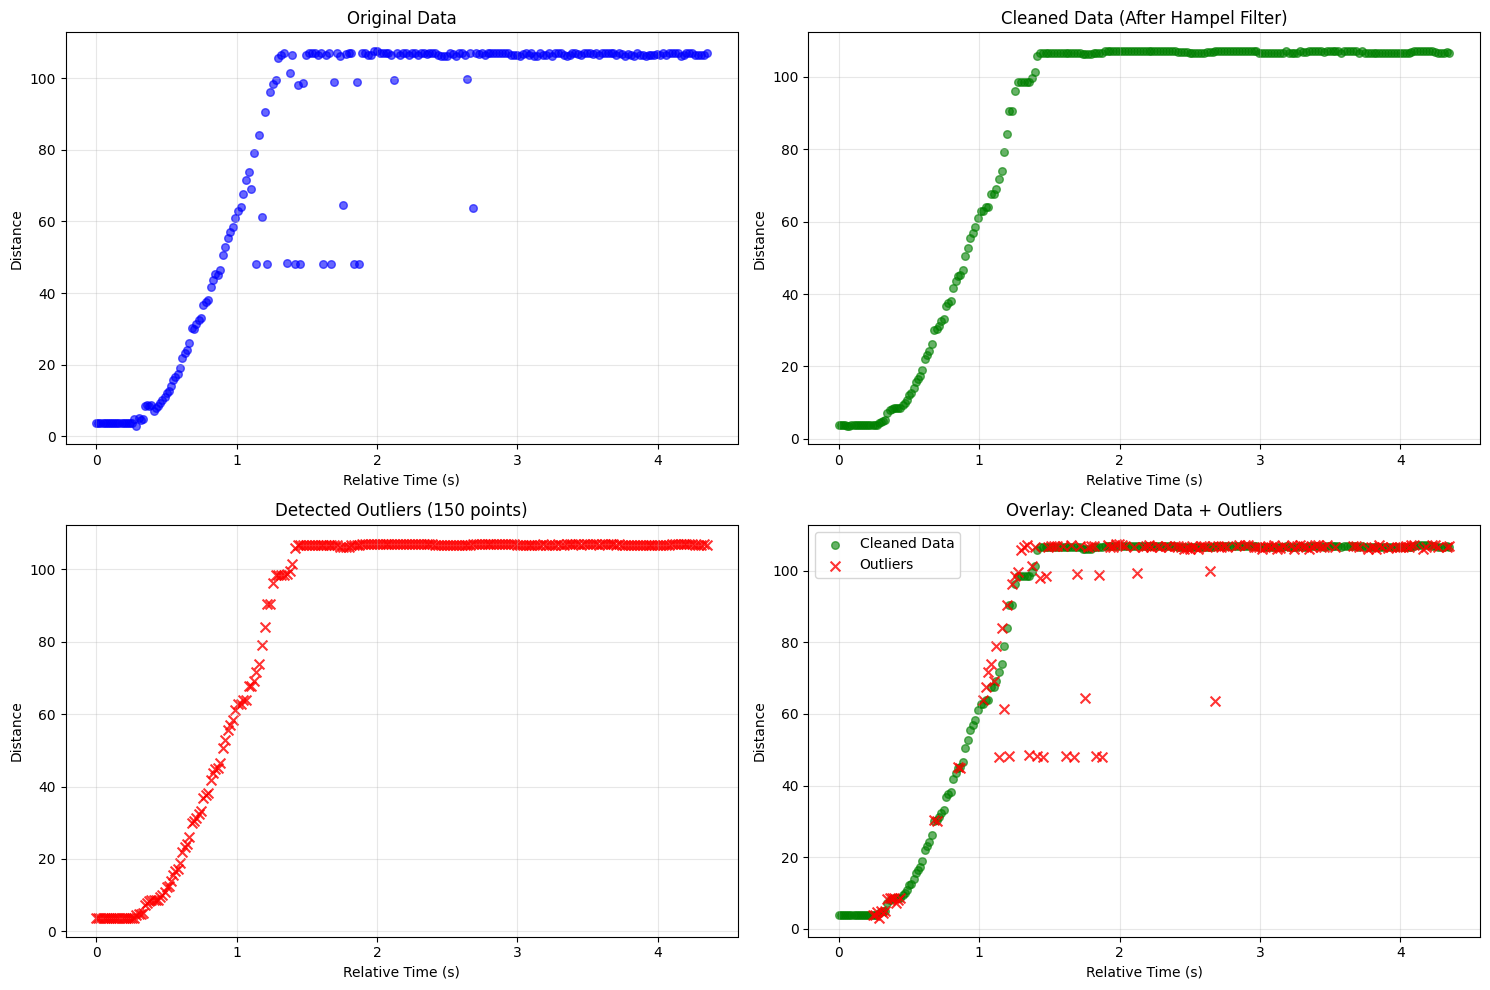

In [18]:
df = pd.read_csv('./assets/DATA/speed_test.csv')
print("\nApplying Hampel filter...")

distance_filtered, distance_outlier_idx, distance_outlier_vals = filtro_hampel(
    df['distance'], window_size=13, threshold=0
)

cleaned_df = df.copy()
cleaned_df['distance'] = distance_filtered

all_outlier_indices = list(set(distance_outlier_idx))
outliers_df = df.iloc[all_outlier_indices].copy()

for idx in all_outlier_indices:
    outliers_df.loc[outliers_df.index[all_outlier_indices.index(idx)]]

try:
    cleaned_df.to_csv('./assets/DATA/cleaned_data.csv', index=False)
    outliers_df.to_csv('./assets/DATA/outliers_data.csv', index=False)
    print(f"\nArchivos guardados satisfactoriamente!")
    print(f"- cleaned_data.csv ({len(cleaned_df)} filas)")
    print(f"- outliers_data.csv ({len(outliers_df)} filas)")
except Exception as e:
    print(f"Error al guardar los archivos: {e}")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.scatter(df['relative_time_s'], df['distance'], alpha=0.6, c='blue', s=30)
ax1.set_title('Original Data')
ax1.set_ylabel('Distance')
ax1.set_xlabel('Relative Time (s)')
ax1.grid(True, alpha=0.3)

ax2.scatter(cleaned_df['relative_time_s'], cleaned_df['distance'],alpha=0.6, c='green', s=30)
ax2.set_title('Cleaned Data (After Hampel Filter)')
ax2.set_ylabel('Distance')
ax2.set_xlabel('Relative Time (s)')
ax2.grid(True, alpha=0.3)

if len(outliers_df) > 0:
    ax3.scatter(cleaned_df['relative_time_s'], cleaned_df['distance'],
                alpha=0.8, c='red', s=50, marker='x')
    ax3.set_title(f'Detected Outliers ({len(outliers_df)} points)')
    ax3.set_ylabel('Distance')
    ax3.set_xlabel('Relative Time (s)')
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'No Outliers Detected', ha='center', va='center',
             transform=ax3.transAxes, fontsize=14)
    ax3.set_title('Detected Outliers')

ax4.scatter(cleaned_df['relative_time_s'], cleaned_df['distance'],
            alpha=0.6, c='green', s=30, label='Cleaned Data')
if len(outliers_df) > 0:
    ax4.scatter(outliers_df['relative_time_s'], outliers_df['distance'],
                alpha=0.8, c='red', s=50, marker='x', label='Outliers')
ax4.set_title('Overlay: Cleaned Data + Outliers')
ax4.set_ylabel('Distance')
ax4.set_xlabel('Relative Time (s)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()